# Univariate time series classification with sktime

In this notebook, we will use sktime for univariate time series classification. Here, we have a single time series variable and an associated label for multiple instances. The goal is to find a classifier that can learn the relationship between time series and label and accurately predict the label of new series.

When you have multiple time series variables and want to learn the relationship between them and a label, you can take a look at our [multivariate time series classification notebook](https://github.com/alan-turing-institute/sktime/blob/master/examples/03_classification_multivariate.ipynb).

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.datasets import load_arrow_head
from sktime.series_as_features.compose import FeatureUnion
from sktime.transformers.series_as_features.compose import RowTransformer
from sktime.transformers.series_as_features.reduce import Tabularizer
from sktime.transformers.series_as_features.segment import \
    RandomIntervalSegmenter
from sktime.utils.time_series import time_series_slope
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf

## Load data

In this notebook, we use the [arrow head problem](https://timeseriesclassification.com/description.php?Dataset=ArrowHead).

The arrowhead dataset consists of outlines of the images of arrow heads. The classification of projectile points is an important topic in anthropology. The classes are based on shape distinctions such as the presence and location of a notch in the arrow.

<img src="./img/arrow-heads.png" width="400" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="./img/from-shapes-to-time-series.png" width="400" alt="from shapes to time series">

In [2]:
X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(158, 1) (158,) (53, 1) (53,)


Throughout sktime, the expected data format is a `pd.DataFrame`, but in a slighly unusual format. A single column can contain not only primitives (floats, integers or strings), but also entire time series in form of a `pd.Series` or `np.array`.

In [3]:
# univariate time series input data
X_train.head()

,dim_0
29,0 -1.8293 1 -1.8324 2 -1.8226 3 ...
19,0 -1.8822 1 -1.8806 2 -1.8658 3 ...
149,0 -1.8406 1 -1.8347 2 -1.8162 3 ...
59,0 -1.9969 1 -2.0076 2 -2.0010 3 ...
31,0 -1.9608 1 -1.9304 2 -1.8643 3 ...


In [4]:
# binary target variable
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0' '1' '2'] [58 49 51]


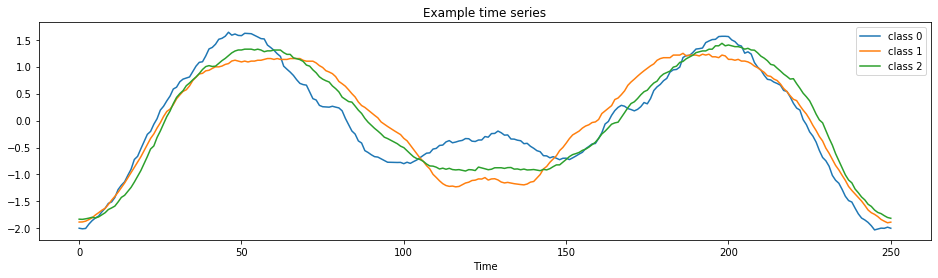

In [5]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

In [6]:
# binary target variable
np.unique(y_train)

array(['0', '1', '2'], dtype=object)

## K-nearest-neighbours classifier for time series
For time series, the most popular k-nearest-neighbours algorithm is based on dynamic time warping (dtw) distance measure.

In [7]:
knn = KNeighborsTimeSeriesClassifier(metric='dtw')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.8301886792452831

## Composable time-series forest
We can specify the time-series tree classifier as a fully modular pipeline using series-to-primitive feature extraction transformers and a final decision tree classifier. For more details, take a look at the [paper](https://www.sciencedirect.com/science/article/pii/S0020025513001473).

In [8]:
from sktime.transformers.series_as_features.summarize import RandomIntervalFeatureExtractor

In [9]:
steps = [
    ('extract', RandomIntervalFeatureExtractor(n_intervals='sqrt', features=[np.mean, np.std, time_series_slope])),
    ('clf', DecisionTreeClassifier())
]
time_series_tree = Pipeline(steps)

To better understand the algorithm, we could write it in an even more modular way:

```python
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals='sqrt')),
    ('transform', FeatureUnion([
        ('mean', RowTransformer(FunctionTransformer(func=np.mean, validate=False))),
        ('std', RowTransformer(FunctionTransformer(func=np.std, validate=False))),
        ('slope', RowTransformer(FunctionTransformer(func=time_series_slope, validate=False)))
    ])),
    ('clf', DecisionTreeClassifier())
]
time_series_tree = Pipeline(steps)
```

We can direclty fit and evaluate the single time series tree (or pipeline).

In [10]:
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.7169811320754716

For time series forest, we can simply use the single tree as the base estimator in the forest ensemble.

In [11]:
tsf = TimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    criterion='entropy',
    bootstrap=True,
    oob_score=True,
    random_state=1
)

Fit and obtain the out-of-bag score:

In [12]:
tsf.fit(X_train, y_train)

if tsf.oob_score:
    print(tsf.oob_score_)

0.8734177215189873


In [13]:
tsf.score(X_test, y_test)

0.7924528301886793

We can also obtain feature importances for the different features and intervals that the algorithms looked at and plot them in a feature importance graph over time.

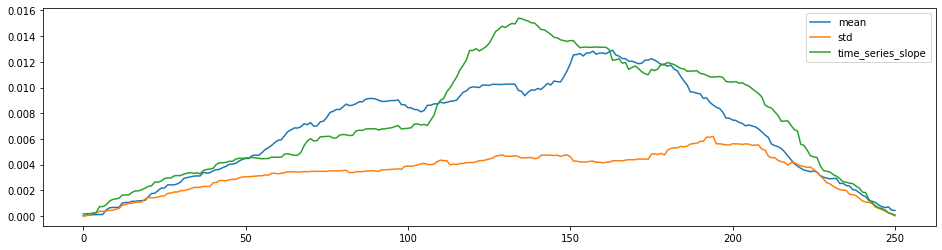

In [14]:
fi = tsf.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
fi.plot(ax=ax);

### RISE

Another popular variant of time series forest is the so-called Random Interval Spectral Ensemble (RISE), which makes use of several series-to-series feature extraction transformers, including:

* Fitted auto-regressive coefficients,
* Estimated autocorrelation coefficients,
* Power spectrum coefficients.

In [15]:
def ar_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    lags = np.minimum(len(x) - 1, maxlag) // 2
    model = AutoReg(endog=x, trend="n", lags=lags)
    return model.fit().params.ravel()

def acf_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    nlags = np.minimum(len(x) - 1, maxlag)
    return acf(x, nlags=nlags, fft=True).ravel()

def powerspectrum(x, **kwargs):
    x = np.asarray(x).ravel()
    fft = np.fft.fft(x)
    ps = fft.real * fft.real + fft.imag * fft.imag
    return ps[:ps.shape[0] // 2].ravel()

The full pipeline of a single tree in RISE is then specified as follows:

In [16]:
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals=1, min_length=5)),
    ('transform', FeatureUnion([
        ('ar', RowTransformer(FunctionTransformer(func=ar_coefs, validate=False))),
        ('acf', RowTransformer(FunctionTransformer(func=acf_coefs, validate=False))),
        ('ps', RowTransformer(FunctionTransformer(func=powerspectrum, validate=False)))
    ])),
    ('tabularise', Tabularizer()),
    ('clf', DecisionTreeClassifier())
]
rise_tree = Pipeline(steps)

rise = TimeSeriesForestClassifier(estimator=rise_tree, n_estimators=50)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.8679245283018868

## Other classifiers
To find out what other algorithms we have implemented in sktime, you can use our utility function:

In [17]:
from sktime.utils import all_estimators
all_estimators(estimator_type="classifier")

[('BOSSEnsemble', sktime.classification.dictionary_based._boss.BOSSEnsemble),
 ('BOSSIndividual',
  sktime.classification.dictionary_based._boss.BOSSIndividual),
 ('ColumnEnsembleClassifier',
  sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier),
 ('ElasticEnsemble',
  sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble),
 ('KNeighborsTimeSeriesClassifier',
  sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier),
 ('MrSEQLClassifier',
  sktime.classification.shapelet_based.mrseql.mrseql.MrSEQLClassifier),
 ('ProximityForest',
  sktime.classification.distance_based._proximity_forest.ProximityForest),
 ('ProximityStump',
  sktime.classification.distance_based._proximity_forest.ProximityStump),
 ('ProximityTree',
  sktime.classification.distance_based._proximity_forest.ProximityTree),
 ('RandomIntervalSpectralForest',
  sktime.classification.frequency_based._rise.RandomIntervalSpectralForest),
 ('ShapeletTransfo